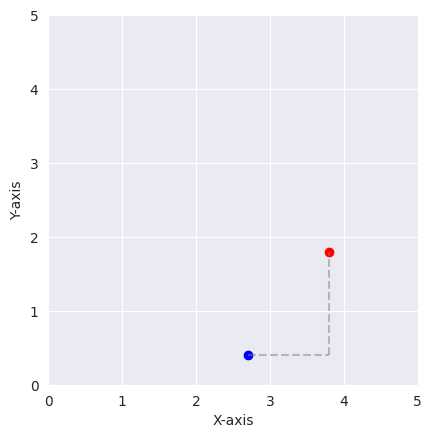

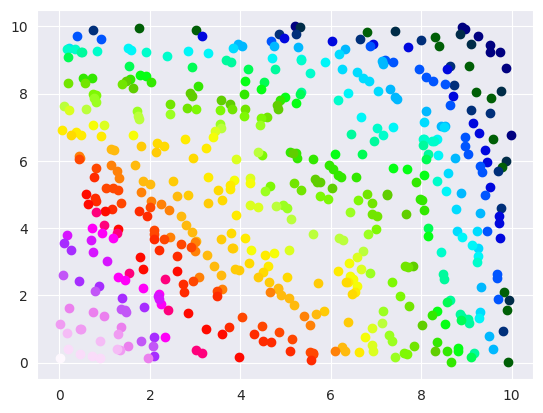

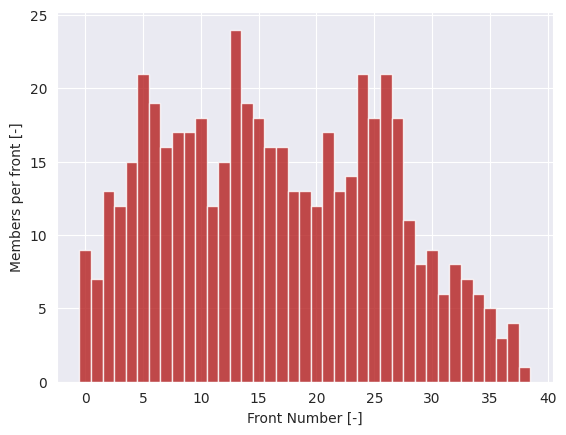

In [1]:
# Surpresses printing from other notebook
import io
import sys

original_stdout = sys.stdout
sys.stdout = io.StringIO()
%run nsga-ii.ipynb
sys.stdout = original_stdout

# Beam optimization

In this exercise, we will use multi-objective optimization to find the optimal beam parameters considering weight and deflection. For optimization, we will use the Non-dominating Sorting Genetic Algorithm II.

<img src="assets/charles_kuonen_bridge.jpg" width="640">

# Imports

In [2]:
from tqdm.notebook import tqdm
import random

## Beam Modeling

In [3]:
density = 7800  # [kg/m^3] density of beam
F_ext = 2000  # [N] force applied to the end of the beam
E = 207e9  # [Pa] young's modulus of beam


def f_weight(d, l):
    # minimize weight
    return density * l * np.pi * d**2 / 4.0


def f_deflection(d, l):
    # minimize deflection
    return 64.0 * F_ext * l**3 / (3.0 * E * np.pi * d**4)

## Evolve solutions

In [38]:
num_generations = 1000
population_size = 64
num_parameters = 2
value_ranges = [(0.01, 0.05), (0.2, 1.0)]

crossover_probability = 0.5
mutation_probability = 0.15

objective_functions = [f_weight, f_deflection]

# Get initial population
population = initialise_population(population_size, num_parameters, value_ranges)
fitness = evaluate_population(population, objective_functions)
pareto_fronts, population_rank = fast_nondominated_sort(fitness)

## Create children
# Mutation and Crossover
population = mutate_population(population, mutation_probability)

# Tournament selection 1
children = np.zeros((population_size, num_parameters))
offspring_size = int(population_size / 2)

for i in range(offspring_size):
    parent_1_index = tournament_selection(
        tournament_size, population_rank, crowding_distances
    )
    parent_2_index = parent_1_index

    while parent_1_index == parent_2_index:
        parent_2_index = tournament_selection(
            tournament_size, population_rank, crowding_distances
        )

    parent_1 = population[parent_1_index, :]
    parent_2 = population[parent_2_index, :]

    child_1, child_2 = stochastic_one_point_crossover(
        parent_1, parent_2, crossover_probability
    )

    children[i, :] = child_1
    children[i + offspring_size, :] = child_2


for gen in tqdm(range(num_generations)):
    population = np.vstack((population, children))

    children = []
    front_num = 0
    while len(children) + len(pareto_fronts[front_num]) < offspring_size:
        for i in pareto_fronts[front_num]:
            children.append(population[i, :])
        front_num += 1

    children = np.array(children)

    distances = compute_crowding_distance(fitness, pareto_fronts[front_num])

    fitness = evaluate_population(population, objective_functions)
    pareto_fronts, population_rank = fast_nondominated_sort(fitness)

  0%|          | 0/1000 [00:00<?, ?it/s]

Acc children: [[ 0.039   2.1373]
 [ 0.0366  0.9126]
 [-0.173   0.9477]
 [ 0.1337  0.971 ]
 [ 0.0405  0.9338]
 [ 0.0394  0.9447]
 [ 0.0147  0.7282]
 [ 0.0481  0.8685]
 [-0.7796  0.8601]
 [ 0.0371  0.8759]
 [ 0.0253  0.7978]
 [ 0.0299  0.8429]
 [ 0.0426  0.8079]
 [ 0.0421  0.8108]
 [ 0.0146  0.7508]
 [ 0.0151  0.6832]
 [ 0.0481  0.8614]
 [ 0.0358  0.8101]
 [-0.5606  0.6412]
 [ 0.0249  0.616 ]
 [ 0.0284  0.7177]
 [ 0.1847  0.5559]
 [ 0.0463  0.5411]
 [ 0.0496  0.5728]]
Length pareto front: 8


RuntimeError: No active exception to reraise

In [29]:
class Evolution:
    def __init__(
        self,
        problem,
        num_of_generations=1000,
        num_of_individuals=100,
        num_of_tour_particips=2,
        tournament_prob=0.9,
        crossover_param=2,
        mutation_param=5,
    ):
        self.utils = NSGA2Utils(
            problem,
            num_of_individuals,
            num_of_tour_particips,
            tournament_prob,
            crossover_param,
            mutation_param,
        )
        self.population = None
        self.num_of_generations = num_of_generations
        self.on_generation_finished = []
        self.num_of_individuals = num_of_individuals

    def evolve(self):
        # First population
        self.population = self.utils.create_initial_population()
        self.utils.fast_nondominated_sort(self.population)
        for front in self.population.fronts:
            self.utils.calculate_crowding_distance(front)
        children = self.utils.create_children(self.population)
        self.population.extend(children)

        returned_population = None

        for i in tqdm(range(self.num_of_generations)):
            # Fronts
            self.utils.fast_nondominated_sort(self.population)

            # Init new population
            new_population = Population()
            front_num = 0
            while (
                len(new_population) + len(self.population.fronts[front_num])
                <= self.num_of_individuals
            ):
                self.utils.calculate_crowding_distance(
                    self.population.fronts[front_num]
                )
                new_population.extend(self.population.fronts[front_num])
                front_num += 1

            self.utils.calculate_crowding_distance(self.population.fronts[front_num])
            self.population.fronts[front_num].sort(
                key=lambda individual: individual.crowding_distance, reverse=True
            )
            new_population.extend(
                self.population.fronts[front_num][
                    0 : self.num_of_individuals - len(new_population)
                ]
            )
            returned_population = self.population

            self.population = new_population

            # New population
            self.utils.fast_nondominated_sort(self.population)
            for front in self.population.fronts:
                self.utils.calculate_crowding_distance(front)
            children = self.utils.create_children(self.population)
            self.population.extend(children)

        return returned_population.fronts[0]